In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
meta_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")

In [3]:
known_df = pd.read_excel("../data/known_genes/known_obesity_genes.xlsx")

In [4]:
discovery_id = meta_df.ID
known_id =known_df.ID

In [5]:
aou_df = pd.read_csv("../data/meta/bmi_aou_meta_w_samples.csv.gz")
ukb_df = pd.read_csv("../data/meta/bmi_ukb_meta_w_samples.csv.gz")

In [6]:
multi_ancestry_df = aou_df.merge(ukb_df, on="ID")

In [7]:
multi_ancestry_df["variance"] = multi_ancestry_df.loc[:, [c for c in multi_ancestry_df.columns if "BETA_" in c]].var(axis=1)

In [8]:
disc_var_df = multi_ancestry_df.loc[multi_ancestry_df.ID.isin(discovery_id), ["ID", "variance"]]
disc_var_df["status"] = "discovery"
known_var_df = multi_ancestry_df.loc[multi_ancestry_df.ID.isin(known_id), ["ID", "variance"]]
known_var_df["status"] = "known"

In [9]:
var_df = pd.concat((disc_var_df, known_var_df))

In [10]:
var_df.drop_duplicates("ID").to_excel("../data/meta/assoc_variance.xlsx", index=False)

# Plotting

In [12]:
# add per gene beta
disc_df = meta_df.copy()
disc_df["gene"] = disc_df.ID.str.split(".", expand=True).iloc[:, 0]
disc_df = disc_df.loc[disc_df.groupby('gene')['p_value'].idxmin()]
disc_dict = disc_df.loc[:, ["gene", "beta"]].set_index("gene").to_dict()["beta"]


In [13]:
known_beta_df = known_df.copy()
known_beta_df["gene"] = known_beta_df.ID.str.split(".", expand=True).iloc[:, 0]
known_beta_df = known_beta_df.loc[known_beta_df.groupby('gene')['p_value'].idxmin()]
known_beta_dict = known_beta_df.loc[:, ["gene", "beta"]].set_index("gene").to_dict()["beta"]

In [14]:
beta_dict = disc_dict.copy()
beta_dict.update(known_beta_dict)

In [15]:
def highest_effect(x):
    x=list(x)
    return x[np.argmax(np.abs(x))]

var_df["gene"] = var_df.ID.str.split(".", expand=True).iloc[:, 0]
var_df["beta"] = var_df.gene.map(beta_dict)
var_plot_df = var_df.groupby("gene").agg({
    "beta": lambda x: highest_effect(x),
    "variance": "min",
    "status": lambda x: "known" if "known" in list(x) else "discovery"
    })

In [21]:
var_plot_df.loc[(var_plot_df.beta<-1)&(var_plot_df.variance<0.16)]

,beta,variance,status
gene,,,
B3GNT2,-1.314586,0.059423,discovery
CCT7,-1.082937,0.132306,discovery
SNAP29,-1.058835,0.100767,discovery
TSPAN4,-1.083205,0.159007,discovery
VIRMA,-1.634444,0.130712,discovery


In [19]:
var_plot_df.sort_values("beta").head(10)

,beta,variance,status
gene,,,
DCUN1D3,-3.842606,1.134727,discovery
NEUROD6,-3.024546,1.851669,discovery
SH3GL2,-2.339171,0.622385,discovery
AQP3,-1.821065,0.736669,discovery
RABEP1,-1.709539,0.802926,discovery
SCFD1,-1.666230,0.390603,discovery
P2RY1,-1.660889,0.929977,discovery
VIRMA,-1.634444,0.130712,discovery
RPS9,-1.612145,0.602098,discovery


In [55]:
var_plot_df.sort_values("beta")

,beta,variance,status
gene,,,
DCUN1D3,-3.842606,1.134727,discovery
NEUROD6,-3.024546,1.851669,discovery
SH3GL2,-2.339171,0.622385,discovery
AQP3,-1.821065,0.736669,discovery
RABEP1,-1.709539,0.802926,discovery
...,...,...,...
BSN,2.689351,1.585560,known
TOX4,2.848302,7.687191,known
DIDO1,3.026344,1.924068,known


/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_24251/156229514.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-0.1, 15)


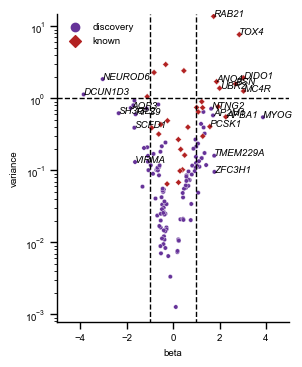

In [78]:
fig, ax = plt.subplots(1,1, figsize=(3,4))
sns.scatterplot(
    data=var_plot_df, x="beta", y="variance", 
    s=10, hue="status", palette=["rebeccapurple", "firebrick"], style="status", markers=["o", "D"], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.hlines([1], xmin=-5, xmax=5, lw=1, color="k", ls="--")
ax.vlines([-1, 1], ymin=-0.1, ymax=15, lw=1, color="k", ls="--")
ax.set_yscale('log')
ax.set_xlim(-5, 5)
ax.set_ylim(-0.1, 15)

for info in var_plot_df.loc[(var_plot_df.beta.abs()>1.5)&(var_plot_df.variance<0.75)].itertuples():
    ax.text(info.beta, info.variance, info.Index, fontdict={"fontsize": 7, "fontstyle": "italic"})

for info in var_plot_df.loc[(var_plot_df.beta.abs()>1.5)&(var_plot_df.variance>1)].itertuples():
    ax.text(info.beta, info.variance, info.Index, fontdict={"fontsize": 7, "fontstyle": "italic"})

ax.legend(frameon=False)

In [87]:
var_plot_df.loc[var_plot_df.index=="GPR75"]

,beta,variance,status
gene,,,
GPR75,-1.112982,1.056395,known


In [83]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [84]:
save_pdf("../data/meta/pop_variance.pdf", fig)

In [43]:
multi_ancestry_sel_df.sort_values("var")

,ID,beta,p_value,BETA_british,nsamples_british,p_value_british,BETA_nonbritish,nsamples_nonbritish,p_value_nonbritish,BETA_eur,nsamples_eur,p_value_eur,BETA_afr,nsamples_afr,p_value_afr,BETA_oth,nsamples_oth,p_value_oth,var
32,NACC2.PTV_Missense_lenient.0.001,1.079929,0.000000e+00,0.858017,31.0,2.921965e-01,0.870193,11.0,0.537332,1.263110,61.0,1.540852e-01,1.11252,6.0,0.733545,1.341540,5.0,0.652836,0.048968
17,B3GNT2.PTV_Missense_lenient.0.001,-1.314586,0.000000e+00,-1.358020,32.0,9.126621e-02,-1.419680,5.0,0.544010,-0.999779,26.0,4.614312e-01,-1.08076,8.0,0.702878,-1.587060,12.0,0.410072,0.059423
64,ZFC3H1.PTV_Missense_lenient.0.001,1.778645,0.000000e+00,1.601380,88.0,7.622019e-04,1.850410,9.0,0.234891,2.322640,25.0,9.306578e-02,1.85037,16.0,0.370669,1.537380,10.0,0.466010,0.095347
63,ZFC3H1.PTV_Missense_strict.0.001,1.778645,0.000000e+00,1.601380,88.0,7.622019e-04,1.850410,9.0,0.234891,2.322640,25.0,9.306578e-02,1.85037,16.0,0.370669,1.537380,10.0,0.466010,0.095347
62,ZFC3H1.PTV.0.001,1.778645,0.000000e+00,1.601380,88.0,7.622019e-04,1.850410,9.0,0.234891,2.322640,25.0,9.306578e-02,1.85037,16.0,0.370669,1.537380,10.0,0.466010,0.095347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,UBR2.PTV.0.001,2.003448,1.665166e-07,2.084470,117.0,5.053474e-07,1.897140,13.0,0.143459,2.070330,53.0,2.938529e-02,3.57943,15.0,0.083253,0.261884,10.0,0.901173,1.384007
69,BSN.PTV.0.001,2.689351,1.704959e-08,2.944980,65.0,1.363547e-07,1.294120,7.0,0.463935,3.569580,40.0,1.103088e-03,3.19382,36.0,0.018374,0.714713,7.0,0.776775,1.585560
70,BSN.PTV_Missense_strict.0.001,2.689351,1.704959e-08,2.944980,65.0,1.363547e-07,1.294120,7.0,0.463935,3.569580,40.0,1.103088e-03,3.19382,36.0,0.018374,0.714713,7.0,0.776775,1.585560
2,NEUROD6.PTV.0.001,-3.024546,1.807681e-07,-1.322310,10.0,3.485531e-01,-3.651850,3.0,0.176056,-4.388620,4.0,2.043666e-01,-3.83190,2.0,0.498294,-1.756100,1.0,0.792313,1.851669


In [36]:
multi_ancestry_sel_df.loc[multi_ancestry_sel_df.ID.isin(multi_ancestry_sel_df.loc[:, ["ID"] + [c for c in multi_ancestry_sel_df.columns if "BETA_" in c]].set_index("ID").var(axis=1).sort_values().head(50).index)]

,ID,beta,p_value,BETA_british,nsamples_british,p_value_british,BETA_nonbritish,nsamples_nonbritish,p_value_nonbritish,BETA_eur,nsamples_eur,p_value_eur,BETA_afr,nsamples_afr,p_value_afr,BETA_oth,nsamples_oth,p_value_oth
10,SCFD1.PTV.0.001,-1.666230,2.079829e-08,-1.010360,48.0,1.164201e-01,-2.216090,7.0,0.209406,-2.381190,28.0,0.068435,-1.288120,7.0,0.670331,-1.237770,7.0,0.623330
11,SCFD1.PTV_Missense_strict.0.001,-1.666230,2.079829e-08,-1.010360,48.0,1.164201e-01,-2.216090,7.0,0.209406,-2.381190,28.0,0.068435,-1.288120,7.0,0.670331,-1.237770,7.0,0.623330
13,VIRMA.PTV_Missense_lenient.0.001,-1.634444,0.000000e+00,-1.258690,117.0,2.274574e-03,-2.081560,27.0,0.020672,-1.538400,42.0,0.149481,-1.176560,20.0,0.511051,-1.676120,16.0,0.315000
15,VIRMA.PTV.0.001,-1.528392,0.000000e+00,-1.197350,114.0,4.161597e-03,-1.833160,25.0,0.049887,-1.762540,39.0,0.111543,-0.929043,19.0,0.612981,-1.700580,15.0,0.323611
16,VIRMA.PTV_Missense_strict.0.001,-1.528392,0.000000e+00,-1.197350,114.0,4.161597e-03,-1.833160,25.0,0.049887,-1.762540,39.0,0.111543,-0.929043,19.0,0.612981,-1.700580,15.0,0.323611
17,B3GNT2.PTV_Missense_lenient.0.001,-1.314586,0.000000e+00,-1.358020,32.0,9.126621e-02,-1.419680,5.0,0.544010,-0.999779,26.0,0.461431,-1.080760,8.0,0.702878,-1.587060,12.0,0.410072
18,PANK1.PTV.0.001,-1.249794,3.802613e-09,-1.151840,43.0,9.045446e-02,-1.694810,21.0,0.096636,-0.680102,68.0,0.417403,-1.672060,41.0,0.181087,-0.915722,32.0,0.437271
21,CDK7.PTV.0.001,-1.110133,2.836056e-09,-0.896399,89.0,5.825457e-02,-1.387660,22.0,0.163858,-1.191980,30.0,0.345234,-1.783170,15.0,0.388442,-0.587241,23.0,0.672888
22,CDK7.PTV_Missense_strict.0.001,-1.110133,2.836056e-09,-0.896399,89.0,5.825457e-02,-1.387660,22.0,0.163858,-1.191980,30.0,0.345234,-1.783170,15.0,0.388442,-0.587241,23.0,0.672888
23,TSPAN4.PTV_Missense_strict.0.001,-1.083205,3.688958e-07,-0.571635,298.0,2.737663e-02,-1.460330,44.0,0.038372,-1.140310,73.0,0.158988,-1.362120,13.0,0.539670,-1.582490,26.0,0.226235


In [44]:
ukb_df.loc[ukb_df.ID.str.contains("GPR75"), ["ID"]+[c for c in ukb_df.columns if "_british" in c]]

,ID,CHROM_british,GENPOS_british,ALLELE0_british,ALLELE1_british,A1FREQ_british,N_british,TEST_british,BETA_british,SE_british,CHISQ_british,LOG10P_british,EXTRA_british,p_value_british,nsamples_british
6665,GPR75.PTV.0.001,2.0,53853238.0,ref,PTV.0.001,0.000159,402034.0,ADD,-1.55059,0.395801,15.3475,4.04848,NaN,0.000089,128.0
6666,GPR75.PTV_Missense_strict.0.001,2.0,53853238.0,ref,PTV_Missense_strict.0.001,0.000159,402034.0,ADD,-1.55059,0.395801,15.3475,4.04848,NaN,0.000089,128.0
6667,GPR75.PTV_Missense_lenient.0.001,2.0,53853238.0,ref,PTV_Missense_lenient.0.001,0.000162,402034.0,ADD,-1.53135,0.392745,15.2029,4.01524,NaN,0.000097,130.0


In [14]:
ukb_df.loc[ukb_df.p_value_nonbritish<8.34e-7].sort_values("p_value_british").head(50)

,CHROM_british,GENPOS_british,ID,ALLELE0_british,ALLELE1_british,A1FREQ_british,N_british,TEST_british,BETA_british,SE_british,...,A1FREQ_nonbritish,N_nonbritish,TEST_nonbritish,BETA_nonbritish,SE_nonbritish,CHISQ_nonbritish,LOG10P_nonbritish,EXTRA_nonbritish,p_value_nonbritish,nsamples_nonbritish
12864,4.0,56395519.0,PPAT.PTV.0.001,ref,PTV.0.001,0.00005,402034.0,ADD,0.43281,0.705591,...,0.000015,65192.0,ADD,16.4858,3.30423,24.8932,6.21756,NaN,6.059545e-07,2.0


In [15]:
ukb_df.loc[ukb_df.p_value_nonbritish<8.34e-7].sort_values("p_value_nonbritish").head(50)

,CHROM_british,GENPOS_british,ID,ALLELE0_british,ALLELE1_british,A1FREQ_british,N_british,TEST_british,BETA_british,SE_british,...,A1FREQ_nonbritish,N_nonbritish,TEST_nonbritish,BETA_nonbritish,SE_nonbritish,CHISQ_nonbritish,LOG10P_nonbritish,EXTRA_nonbritish,p_value_nonbritish,nsamples_nonbritish
12864,4.0,56395519.0,PPAT.PTV.0.001,ref,PTV.0.001,0.00005,402034.0,ADD,0.43281,0.705591,...,0.000015,65192.0,ADD,16.4858,3.30423,24.8932,6.21756,NaN,6.059545e-07,2.0


In [17]:
aou_df.loc[aou_df.p_value_oth<8.34e-7].sort_values("p_value_oth").head(50)

,CHROM_eur,GENPOS_eur,ID,ALLELE0_eur,ALLELE1_eur,A1FREQ_eur,N_eur,TEST_eur,BETA_eur,SE_eur,...,A1FREQ_oth,N_oth,TEST_oth,BETA_oth,SE_oth,CHISQ_oth,LOG10P_oth,EXTRA_oth,p_value_oth,nsamples_oth
45610,19.0,1418257.0,DAZAP1.PTV.0.001,ref,PTV.0.001,0.000055,127573.0,ADD,-3.299910,1.84759,...,0.000010,51930.0,ADD,41.9365,6.66523,39.5873,9.50345,NaN,3.137256e-10,1.0
45611,19.0,1418257.0,DAZAP1.PTV_Missense_strict.0.001,ref,PTV_Missense_strict.0.001,0.000055,127573.0,ADD,-3.299910,1.84759,...,0.000010,51930.0,ADD,41.9365,6.66523,39.5873,9.50345,NaN,3.137256e-10,1.0
28671,11.0,124753657.0,ESAM.PTV.0.001,ref,PTV.0.001,0.000086,127573.0,ADD,0.728604,1.47448,...,0.000029,52096.0,ADD,20.2440,3.84907,27.6619,6.84019,NaN,1.444808e-07,3.0
28672,11.0,124753657.0,ESAM.PTV_Missense_strict.0.001,ref,PTV_Missense_strict.0.001,0.000086,127573.0,ADD,0.728604,1.47448,...,0.000029,52096.0,ADD,20.2440,3.84907,27.6619,6.84019,NaN,1.444808e-07,3.0
28673,11.0,124753657.0,ESAM.PTV_Missense_lenient.0.001,ref,PTV_Missense_lenient.0.001,0.000102,127573.0,ADD,0.604435,1.35634,...,0.000029,52096.0,ADD,20.2440,3.84907,27.6619,6.84019,NaN,1.444808e-07,3.0
34074,12.0,125326629.0,TMEM132B.PTV.0.001,ref,PTV.0.001,0.000094,127573.0,ADD,1.297630,1.41153,...,0.000058,52096.0,ADD,13.7163,2.72265,25.3800,6.32718,NaN,4.707822e-07,6.0
34075,12.0,125326629.0,TMEM132B.PTV_Missense_strict.0.001,ref,PTV_Missense_strict.0.001,0.000094,127573.0,ADD,1.297630,1.41153,...,0.000058,52096.0,ADD,13.7163,2.72265,25.3800,6.32718,NaN,4.707822e-07,6.0
34076,12.0,125326629.0,TMEM132B.PTV_Missense_lenient.0.001,ref,PTV_Missense_lenient.0.001,0.000094,127573.0,ADD,1.297630,1.41153,...,0.000058,52096.0,ADD,13.7163,2.72265,25.3800,6.32718,NaN,4.707822e-07,6.0


In [39]:
aou_df.loc[aou_df.ID.str.contains("DIDO1"), ["ID"]+[c for c in aou_df.columns if "_eur" in c]]

,ID,CHROM_eur,GENPOS_eur,ALLELE0_eur,ALLELE1_eur,A1FREQ_eur,N_eur,TEST_eur,BETA_eur,SE_eur,CHISQ_eur,LOG10P_eur,EXTRA_eur,p_value_eur,nsamples_eur
49210,DIDO1.PTV.0.001,20.0,62879310.0,ref,PTV.0.001,0.000153,127573.0,ADD,2.37982,1.107220,4.61973,1.500230,NaN,0.031606,39.0
49211,DIDO1.PTV_Missense_strict.0.001,20.0,62879310.0,ref,PTV_Missense_strict.0.001,0.000153,127573.0,ADD,2.37982,1.107220,4.61973,1.500230,NaN,0.031606,39.0
49212,DIDO1.PTV_Missense_lenient.0.001,20.0,62879310.0,ref,PTV_Missense_lenient.0.001,0.000267,127573.0,ADD,1.30394,0.838635,2.41753,0.920876,NaN,0.119984,68.0


In [23]:
aou_df.loc[aou_df.p_value_eur<8.34e-7].sort_values("p_value_eur").loc[:, ["ID"]+[c for c in aou_df.columns if "_eur" in c]]

,ID,CHROM_eur,GENPOS_eur,ALLELE0_eur,ALLELE1_eur,A1FREQ_eur,N_eur,TEST_eur,BETA_eur,SE_eur,CHISQ_eur,LOG10P_eur,EXTRA_eur,p_value_eur,nsamples_eur
44394,MC4R.PTV_Missense_lenient.0.001,18.0,60371367.0,ref,PTV_Missense_lenient.0.001,0.000596,127573.0,ADD,3.40416,0.561333,36.7773,8.87803,NaN,1.324250e-09,152.0
44393,MC4R.PTV_Missense_strict.0.001,18.0,60371367.0,ref,PTV_Missense_strict.0.001,0.000400,127573.0,ADD,4.07105,0.685106,35.3100,8.55101,NaN,2.811836e-09,102.0
32529,HECTD4.PTV.0.001,12.0,112162504.0,ref,PTV.0.001,0.000208,127573.0,ADD,5.63439,0.949972,35.1780,8.52158,NaN,3.008985e-09,53.0
32530,HECTD4.PTV_Missense_strict.0.001,12.0,112162504.0,ref,PTV_Missense_strict.0.001,0.000208,127573.0,ADD,5.63439,0.949972,35.1780,8.52158,NaN,3.008985e-09,53.0
32531,HECTD4.PTV_Missense_lenient.0.001,12.0,112162504.0,ref,PTV_Missense_lenient.0.001,0.000208,127573.0,ADD,5.63439,0.949972,35.1780,8.52158,NaN,3.008985e-09,53.0
36846,YLPM1.PTV_Missense_lenient.0.001,14.0,74763537.0,ref,PTV_Missense_lenient.0.001,0.000321,127573.0,ADD,4.25646,0.763791,31.0561,7.60088,NaN,2.506802e-08,82.0
44392,MC4R.PTV.0.001,18.0,60371367.0,ref,PTV.0.001,0.000345,127573.0,ADD,3.99908,0.737549,29.3994,7.22992,NaN,5.889521e-08,88.0
36844,YLPM1.PTV.0.001,14.0,74763537.0,ref,PTV.0.001,0.000317,127573.0,ADD,4.07591,0.768490,28.1302,6.94531,NaN,1.134201e-07,81.0
36845,YLPM1.PTV_Missense_strict.0.001,14.0,74763537.0,ref,PTV_Missense_strict.0.001,0.000317,127573.0,ADD,4.07591,0.768490,28.1302,6.94531,NaN,1.134201e-07,81.0
30726,SLC1A2.PTV.0.001,11.0,35254784.0,ref,PTV.0.001,0.000063,127573.0,ADD,8.79667,1.728880,25.8884,6.44161,NaN,3.617346e-07,16.0


In [17]:
aou_df.loc[aou_df.p_value_afr<8.34e-7].sort_values("p_value_afr").head(50)

,CHROM_eur,GENPOS_eur,ID,ALLELE0_eur,ALLELE1_eur,A1FREQ_eur,N_eur,TEST_eur,BETA_eur,SE_eur,...,A1FREQ_oth,N_oth,TEST_oth,BETA_oth,SE_oth,CHISQ_oth,LOG10P_oth,EXTRA_oth,p_value_oth,nsamples_oth
18238,6.0,78940743.0,PHIP.PTV.0.001,ref,PTV.0.001,0.000141,127573.0,ADD,0.198750,1.15315,...,0.000115,52096.0,ADD,-1.79337,1.92529,0.867657,0.453945,NaN,0.351605,12.0
18239,6.0,78940743.0,PHIP.PTV_Missense_strict.0.001,ref,PTV_Missense_strict.0.001,0.000145,127573.0,ADD,0.099529,1.13748,...,0.000115,52096.0,ADD,-1.79337,1.92529,0.867657,0.453945,NaN,0.351605,12.0
18240,6.0,78940743.0,PHIP.PTV_Missense_lenient.0.001,ref,PTV_Missense_lenient.0.001,0.000153,127573.0,ADD,-0.048838,1.10794,...,0.000125,52096.0,ADD,-1.64974,1.84975,0.795438,0.428919,NaN,0.372461,13.0


In [18]:
aou_df.loc[aou_df.p_value_oth<8.34e-7].sort_values("p_value_oth").head(50)

,CHROM_eur,GENPOS_eur,ID,ALLELE0_eur,ALLELE1_eur,A1FREQ_eur,N_eur,TEST_eur,BETA_eur,SE_eur,...,A1FREQ_oth,N_oth,TEST_oth,BETA_oth,SE_oth,CHISQ_oth,LOG10P_oth,EXTRA_oth,p_value_oth,nsamples_oth
45610,19.0,1418257.0,DAZAP1.PTV.0.001,ref,PTV.0.001,0.000055,127573.0,ADD,-3.299910,1.84759,...,0.000010,51930.0,ADD,41.9365,6.66523,39.5873,9.50345,NaN,3.137256e-10,1.0
45611,19.0,1418257.0,DAZAP1.PTV_Missense_strict.0.001,ref,PTV_Missense_strict.0.001,0.000055,127573.0,ADD,-3.299910,1.84759,...,0.000010,51930.0,ADD,41.9365,6.66523,39.5873,9.50345,NaN,3.137256e-10,1.0
28671,11.0,124753657.0,ESAM.PTV.0.001,ref,PTV.0.001,0.000086,127573.0,ADD,0.728604,1.47448,...,0.000029,52096.0,ADD,20.2440,3.84907,27.6619,6.84019,NaN,1.444808e-07,3.0
28672,11.0,124753657.0,ESAM.PTV_Missense_strict.0.001,ref,PTV_Missense_strict.0.001,0.000086,127573.0,ADD,0.728604,1.47448,...,0.000029,52096.0,ADD,20.2440,3.84907,27.6619,6.84019,NaN,1.444808e-07,3.0
28673,11.0,124753657.0,ESAM.PTV_Missense_lenient.0.001,ref,PTV_Missense_lenient.0.001,0.000102,127573.0,ADD,0.604435,1.35634,...,0.000029,52096.0,ADD,20.2440,3.84907,27.6619,6.84019,NaN,1.444808e-07,3.0
34074,12.0,125326629.0,TMEM132B.PTV.0.001,ref,PTV.0.001,0.000094,127573.0,ADD,1.297630,1.41153,...,0.000058,52096.0,ADD,13.7163,2.72265,25.3800,6.32718,NaN,4.707822e-07,6.0
34075,12.0,125326629.0,TMEM132B.PTV_Missense_strict.0.001,ref,PTV_Missense_strict.0.001,0.000094,127573.0,ADD,1.297630,1.41153,...,0.000058,52096.0,ADD,13.7163,2.72265,25.3800,6.32718,NaN,4.707822e-07,6.0
34076,12.0,125326629.0,TMEM132B.PTV_Missense_lenient.0.001,ref,PTV_Missense_lenient.0.001,0.000094,127573.0,ADD,1.297630,1.41153,...,0.000058,52096.0,ADD,13.7163,2.72265,25.3800,6.32718,NaN,4.707822e-07,6.0
